In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/fraud-test/x_testEt.csv
/kaggle/input/frauddetectionetalon/y_train.csv
/kaggle/input/frauddetectionetalon/x_train.csv


In [2]:
#libraries & dependencies
#import pandas as pd
#import numpy as np
#data normalizing
from sklearn.preprocessing import LabelEncoder
#imputation of missing values
from sklearn.impute import SimpleImputer
#visualization
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.compat import v1 as tf_compat_v1
from sklearn import preprocessing, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler

In [3]:
x_train = pd.read_csv('/kaggle/input/frauddetectionetalon/x_train.csv')
y_train = pd.read_csv('/kaggle/input/frauddetectionetalon/y_train.csv')


In [4]:
#print(x_train.head())
#print(y_train.isFraud.sum())
from imblearn.over_sampling import SMOTE

x_train1, x_test, y_train1, y_test = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train)
ss = StandardScaler()
x_train1 = ss.fit_transform(x_train1)
x_test = ss.transform(x_test)
syntheticData = SMOTE(k_neighbors=7)#parameters to be chosen in order to make balanced dataset(not equal)
x_train12, y_train12 = syntheticData.fit_resample(x_train1, y_train1)

In [5]:
y_train1.shape

(413378, 1)

In [6]:
from xgboost import XGBClassifier


clf = XGBClassifier(n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist' 
        tree_method='gpu_hist')   



clf.fit(x_train1, y_train1)


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, eval_metric='auc',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=-1,
              monotone_constraints='()', n_estimators=2000, n_jobs=2,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [7]:
x_t = pd.read_csv('/kaggle/input/fraud-test/x_testEt.csv')

In [8]:
x_t = ss.transform(x_t)

In [9]:
sample_submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

sample_submission['isFraud'] = clf.predict_proba(x_t)[:,1]
sample_submission.to_csv('simple_xgboost.csv')
print(sample_submission)

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


                isFraud
TransactionID          
3663549        0.000541
3663550        0.000172
3663551        0.000641
3663552        0.000241
3663553        0.000116
...                 ...
4170235        0.005206
4170236        0.001189
4170237        0.005116
4170238        0.001119
4170239        0.000203

[506691 rows x 1 columns]


In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import itertools

def define_metrics(y_test, y_predicted, y_predicted_proba):  
    # точность(precision)
    precision = metrics.precision_score(y_test, y_predicted)             
    # Полнота (recall)
    recall = metrics.recall_score(y_test, y_predicted) 
    # F-мера - среднее точности и полноты
    f1 = metrics.f1_score(y_test, y_predicted)    
    # Accuracy – доля правильных ответов алгоритма
    accuracy = metrics.accuracy_score(y_test, y_predicted)
    #Коэффициент корреляции Мэтьюза: +1 представляет идеальное предсказание, 
    # 0 - среднее случайное предсказание и -1 - обратное предсказание. 
    matthews_corrcoef = metrics.matthews_corrcoef(y_test, y_predicted)
    #auc
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predicted)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    try:
        #Функция правдоподобия отвечает на вопрос:«Насколько вероятным, по мнению модели,
        #  был фактически наблюдаемый набор результатов»
        log_loss = metrics.log_loss(y_test, y_predicted_proba)
    except ValueError:
        log_loss = '-'
    
    return ['Accuracy', 'Precision', 'Recall', 'F-score', 'MСС', 'ROC AUC', 'Log Loss'], \
           [accuracy,    precision,   recall,   f1,    matthews_corrcoef,    roc_auc, log_loss]

def plot_confusion_matrix(cm, classes, normalize=False, title='Error matrix', cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if np.isnan(cm[i, j]):
            cm[i, j] = 0.0
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=14)
    
    plt.tight_layout()
    plt.ylabel('True', fontsize=20)
    plt.xlabel('Predicted', fontsize=20)

    return plt

def merge(y_predicted_proba, y_test):
    norm_ind = list(label_encoder.transform(['Normal']))[0]
    y_test_2 = [0 if x == norm_ind else 1 for x in y_test]
    y_predicted_counts_2 = [[x[norm_ind], sum(x) - x[norm_ind]] for x in y_predicted_proba]
    return y_predicted_counts_2, y_test_2

def print_stats(y_predicted_counts_proba, y_test):
    y_predicted_counts = np.array(y_predicted_counts_proba).argmax(axis=-1)
    keys, vals = define_metrics(y_test, y_predicted_counts, y_predicted_counts_proba)
    stats = pd.DataFrame([[round(x, 3) if not type(x) == str else x for x in vals]], columns=keys, index=['    '])
    display(stats)
    
    fig_scale = 0.6
    # В одной строке разместим 2 графика (график, табл)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[int(fig_scale * x) for x in (16, 7)])
    # ROC
    _ = skplt.metrics.plot_roc(y_test, y_predicted_counts_proba, figsize=(int(14*0.7), int(10*0.7)), plot_micro=False, plot_macro=False, ax=axs[0])
    
    
    cm = metrics.confusion_matrix(y_test, y_predicted_counts)
    _ = plot_confusion_matrix(cm, ['Normal', 'Fraud'], normalize=True, title='Confusion matrix')
    plt.show()
    
    return stats

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


177162
Roc Auc Score: 0.9698919844034632
1


,Accuracy,Precision,Recall,F-score,MСС,ROC AUC,Log Loss
,0.986,0.954,0.619,0.751,0.762,0.809,0.05


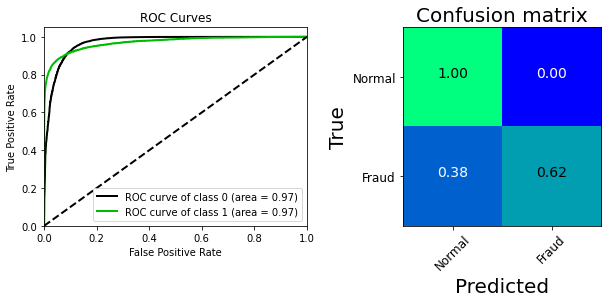

In [11]:
#XGBoostClassifier
clfTestProba = clf.predict_proba(x_test)
clfTestProba12 = clfTestProba.flatten()
clfTestProba1 = []
count = int(clfTestProba12.size)
for i in range(1, count, 2):
    clfTestProba1.append(clfTestProba12[i])
print(len(clfTestProba1))
clfTest = clf.predict(x_test)
#clfTest = clf.predict(x_test)
print("Roc Auc Score:",roc_auc_score(y_test,clfTestProba1))
print(clfTest.max())
stat = list()
stat.append([print_stats(clfTestProba, y_test)])

In [12]:
mlp = MLPClassifier(hidden_layer_sizes=(200,), activation='tanh',solver='adam',learning_rate='adaptive', max_iter=100, early_stopping=True, verbose=True)
clfPercep= mlp.fit(x_train1, y_train1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Iteration 1, loss = 0.12135153
Validation score: 0.971310
Iteration 2, loss = 0.10223409
Validation score: 0.972979
Iteration 3, loss = 0.09554428
Validation score: 0.973850
Iteration 4, loss = 0.08999528
Validation score: 0.974358
Iteration 5, loss = 0.08521821
Validation score: 0.975229
Iteration 6, loss = 0.08100234
Validation score: 0.975471
Iteration 7, loss = 0.07777291
Validation score: 0.975882
Iteration 8, loss = 0.07466841
Validation score: 0.976414
Iteration 9, loss = 0.07188811
Validation score: 0.977236
Iteration 10, loss = 0.06962883
Validation score: 0.976922
Iteration 11, loss = 0.06745093
Validation score: 0.977067
Iteration 12, loss = 0.06567069
Validation score: 0.977212
Iteration 13, loss = 0.06378739
Validation score: 0.977575
Iteration 14, loss = 0.06232159
Validation score: 0.976777
Iteration 15, loss = 0.06092768
Validation score: 0.977357
Iteration 16, loss = 0.05959806
Validation score: 0.977744
Iteration 17, loss = 0.05851181
Validation score: 0.977890
Iterat

[0.99856549 0.00143451]
Roc Auc Score: 0.9057205876359439


,Accuracy,Precision,Recall,F-score,MСС,ROC AUC,Log Loss
,0.977,0.761,0.504,0.607,0.609,0.749,0.094


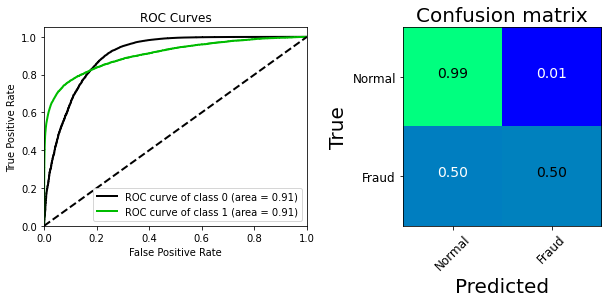

In [13]:
clfTestPercepProba = clfPercep.predict_proba(x_test)
clfTestPercepPredict = clfPercep.predict(x_test)
clfTestPercepProba12 = clfTestPercepProba.flatten()
clfTestPercepProba1 = []
count = int(clfTestPercepProba12.size)
for i in range(1, count, 2):
    clfTestPercepProba1.append(clfTestPercepProba12[i])
print(clfTestPercepProba[0])
#print(clfTestPercep.max())
print("Roc Auc Score:",roc_auc_score(y_test,clfTestPercepProba1))
stat1 = list()
stat1.append([print_stats(clfTestPercepProba, y_test)])

In [14]:
from sklearn.ensemble import RandomForestClassifier
clfForest = RandomForestClassifier(max_depth=45,max_features=30,n_estimators=500, n_jobs=-1, min_samples_leaf=200)
clfForest.fit(x_train1, y_train1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(max_depth=45, max_features=30, min_samples_leaf=200,
                       n_estimators=500, n_jobs=-1)

[0.99194837 0.00805163]
Roc Auc Score: 0.8988687802315222


,Accuracy,Precision,Recall,F-score,MСС,ROC AUC,Log Loss
,0.972,0.883,0.215,0.345,0.427,0.607,0.097


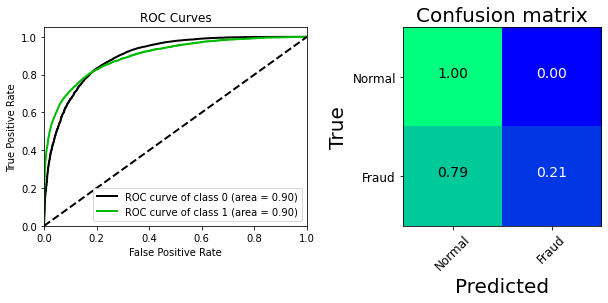

In [15]:
clfTestForestProba = clfForest.predict_proba(x_test)
clfTestForestPredict = clfForest.predict(x_test)
clfTestForestProba12 = clfTestForestProba.flatten()
clfTestForestProba1 = []
count = int(clfTestForestProba12.size)
for i in range(1, count, 2):
    clfTestForestProba1.append(clfTestForestProba12[i])
print(clfTestForestProba[0])
#print(clfTestPercep.max())
print("Roc Auc Score:",roc_auc_score(y_test,clfTestForestProba1))
stat1 = list()
stat1.append([print_stats(clfTestForestProba, y_test)])